In [1]:
import os
import urllib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import pandas as pd

In [2]:
import glob
from osgeo import gdal
import rasterio as rio
import rasterio.plot
import scipy
from scipy import ndimage
from rasterio.enums import Resampling
#import ospybook as pb

In [3]:
%matplotlib inline

In [4]:
dtm_fns = glob.glob('data/**/*.tif',recursive=True)
dtm_fns

['data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_gdaldem_rough.tif',
 'data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif',
 'data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL_gdaldem_tri.tif']

In [5]:
dtm_fn = dtm_fns[0] # change which of the two tif files to look at
imgdir = 'output/'
s='_'.join(dtm_fn.split('_')[7:8])
out_fn = os.path.join(imgdir,'ASO_3m_dtm_USCATM_'+s)
out_fn

'output/ASO_3m_dtm_USCATM_rough.tif'

In [6]:
src = rio.open(dtm_fn)

# New Method from GDAL WARP

In [7]:
out_fn = 'data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif'

In [8]:
src = rio.open(out_fn)
src.close

<function DatasetReader.close>

In [9]:
proj_fn = os.path.splitext(out_fn)[0]+'_gdaldem_tri.tif'

In [10]:
roughness_fn = os.path.splitext(out_fn)[0]+'_gdaldem_rough.tif'

In [11]:
!ls -lah $out_fn

-rw-rw-r-- 1 jovyan users 1.2G Mar  3 17:02 data/mcc_dem_3p0m_agg_TUOtrimmed_MANUAL.tif


In [12]:
#dtm_fn_lzw = os.path.splitext(out_)

In [13]:
#dtm_fn

In [14]:
!pwd

/home/jovyan/project/ICESat-2_Snowdepth


In [15]:
!gdaldem TRI $out_fn $proj_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
!gdaldem roughness $out_fn $roughness_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
src2 = rio.open(proj_fn)

In [18]:
tm2 = src2.read()

In [19]:
tm2[tm2 == (-9999.)] = np.nan

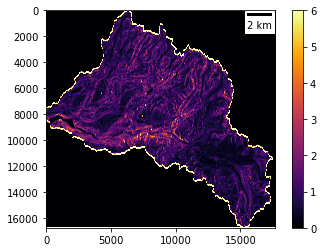

In [20]:
#Plot full range
f,ax = plt.subplots()
plt.imshow(tm2.squeeze(), cmap='inferno', vmin=0, vmax=6)
plt.colorbar()
ax.add_artist(ScaleBar(1));

In [21]:
import numpy.ma as ma
#https://numpy.org/doc/stable/reference/generated/numpy.ma.masked_where.html#numpy.ma.masked_where

In [22]:
import numpy.ma as ma
#https://numpy.org/doc/stable/reference/generated/numpy.ma.masked_where.html#numpy.ma.masked_where
tm2_max_mask = ma.masked_where(tm2 > 6, tm2) #Mask to remove values above a ceratin value

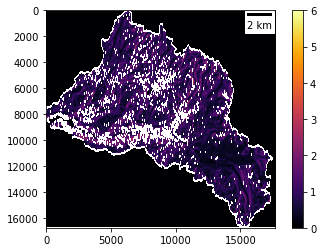

In [23]:
#Plot full range
f,ax = plt.subplots()
plt.imshow(tm2_max_mask.squeeze(), cmap='inferno')
plt.colorbar()
ax.add_artist(ScaleBar(1));

In [ ]:
tm2_max_mask = ma.masked_inside(tm2 > 1, tm2) #Mask to remove values above a ceratin value

In [ ]:
#Plot full range
f,ax = plt.subplots()
plt.imshow(tm2_max_mask.squeeze(), cmap='inferno')
plt.colorbar()
ax.add_artist(ScaleBar(1));

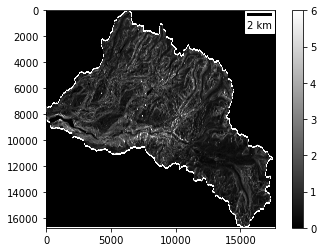

In [21]:
f,ax = plt.subplots()
plt.imshow(tm2.squeeze(), cmap='gray', vmin = 0, vmax = 6)
plt.colorbar()
ax.add_artist(ScaleBar(1));

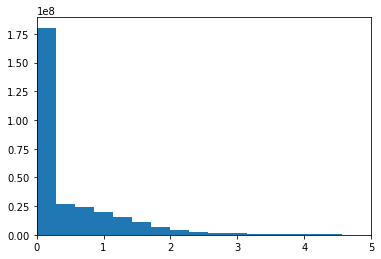

In [21]:
f,ax = plt.subplots()
plt.hist(np.ravel(tm2), bins=10000);
plt.xlim(0, 5);

In [22]:
src3 = rio.open(roughness_fn)

In [23]:
tm3 = src3.read()

In [24]:
tm3[tm3 == (-9999.)] = np.nan

In [25]:
tm3[tm3 > 100] = np.nan

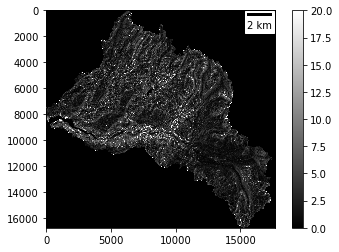

In [26]:
f,ax = plt.subplots()
plt.imshow(tm3.squeeze(), cmap='gray', interpolation='none', vmin = 0, vmax = 20) #, vmin = 0, vmax = 10
plt.colorbar()
ax.add_artist(ScaleBar(1));

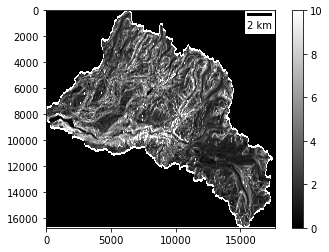

In [27]:
f,ax = plt.subplots()
plt.imshow(tm3.squeeze(), cmap='gray', vmin = 0, vmax = 10) #, vmin = 0, vmax = 10
plt.colorbar()
ax.add_artist(ScaleBar(1));

# Mask Thresholds

In [ ]:
f,ax = plt.subplots()
plt.imshow(tm2.squeeze(), cmap='gray', vmin = 0, vmax = 6)
plt.colorbar()
ax.add_artist(ScaleBar(1));

# New Method from Stack Overflow

In [28]:
import rasterio.windows

window = rasterio.windows.Window(3600, 5600, 1024, 1024)

In [29]:
#Define window bounds
window_bounds = rasterio.windows.bounds(window, src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (265047.0, 4209795.0, 268119.0, 4212867.0)
Window extent:  [265047.0, 268119.0, 4209795.0, 4212867.0]


In [30]:
def rio2ma(fn, b=1, window=None):
    #a = None
    with rio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        return a

In [31]:
tm = rio2ma(dtm_fn, b=1, window=window)

In [32]:
type(tm)

numpy.ma.core.MaskedArray

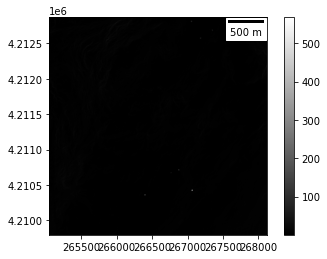

In [33]:
f,ax = plt.subplots()
plt.imshow(tm, cmap='gray', extent=window_extent)
plt.colorbar()
ax.add_artist(ScaleBar(1));

In [34]:
from scipy.ndimage.filters import uniform_filter

radius = 3

def window_stdev(arr, radius):
    c1 = uniform_filter(arr, radius*2, mode='constant', origin=-radius)
    c2 = uniform_filter(arr*arr, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1,:-radius*2+1]

In [35]:
%%timeit
tm_stdev = window_stdev(tm, radius)

51.8 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
tm_stdev

NameError: name 'tm_stdev' is not defined

In [ ]:
type(tm_stdev)

In [ ]:
tm_stdev.shape

In [ ]:
dtm_stdev.squeeze().shape

In [ ]:
f,ax = plt.subplots()
plt.imshow(tm_stdev, cmap='gray', extent=window_extent, vmin=0, vmax=5)
plt.colorbar()
ax.add_artist(ScaleBar(1));

In [ ]:
f,ax = plt.subplots()
plt.hist(np.ravel(tm_stdev), bins=400)
plt.xlim(0, 10);

In [ ]:
dtm = src.read()

In [ ]:
#%%timeit
dtm_stdev = window_stdev(dtm, radius)

In [ ]:
type(dtm_stdev)

In [ ]:
f,ax = plt.subplots()
plt.imshow(dtm_stdev.squeeze(), cmap='gray', extent=window_extent, vmin=0, vmax=5)
plt.colorbar()
ax.add_artist(ScaleBar(1));

# Old Method from https://livebook.manning.com/book/geoprocessing-with-python/chapter-11/50

In [ ]:
!gdalinfo $dtm_fn

In [ ]:
in_ds = gdal.Open(dtm_fn)

In [ ]:
in_band = in_ds.GetRasterBand(1)
in_data = in_band.ReadAsArray()

In [ ]:
in_data[in_data == 0] = np.nan

In [ ]:
# f,ax = plt.subplots()
# colorbar = ax.imshow(in_data);
# f.colorbar(colorbar)

In [ ]:
# Function to save a new raster, from https://livebook.manning.com/book/geoprocessing-with-python/chapter-11/50

def make_raster(in_ds, fn, data, data_type, nodata=None):
    """Create a one-band GeoTIFF.

    in_ds     - datasource to copy projection and geotransform from
    fn        - path to the file to create
    data      - NumPy array containing data to write
    data_type - output data type
    nodata    - optional NoData value
    """
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(
        fn, in_ds.RasterXSize, in_ds.RasterYSize, 1, data_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_band = out_ds.GetRasterBand(1)
    if nodata is not None:
        out_band.SetNoDataValue(nodata)
    out_band.WriteArray(data)
    out_band.FlushCache()
    out_band.ComputeStatistics(False)
    return out_ds

In [ ]:
# Attempt to make a function that creates slices, to then be utilized in a moving window function. From https://livebook.manning.com/book/geoprocessing-with-python/chapter-11/100

def make_slices(data, win_size):
    """Return a list of slices given a window size.
    data     - two-dimensional array to get slices from
    win_size - tuple of (rows, columns) for the moving window
    """
    rows = data.shape[0] - win_size[0] + 1
    cols = data.shape[1] - win_size[1] + 1
    slices = []
    for i in range(win_size[0]):
        for j in range(win_size[1]):
            slices.append(data[i:rows+i, j:cols+j].std())
            return slices

In [ ]:
# Find standard deviation within the file? From https://livebook.manning.com/book/geoprocessing-with-python/chapter-11/103

slices = make_slices(in_data, (3,3))
stacked_data = np.ma.dstack(slices)

In [ ]:
rows, cols = in_band.YSize, in_band.XSize

In [ ]:
stacked_data.dtype

In [ ]:
slices

In [ ]:
out_data = np.ones((rows, cols), np.int8) * -99

In [ ]:
out_data

In [ ]:
type(stacked_data)

In [ ]:
#ndimage.standard_deviation(stacked_data)
#chop out 200x200 piece of the array to test these methods - can also downsample (using Eric's code!).
#from same link: https://stackoverflow.com/questions/18419871/improving-code-efficiency-standard-deviation-on-sliding-windows
radius=3
result = scipy.ndimage.generic_filter(data, np.nanstd, size=2*radius)

In [ ]:
radius=3
result = scipy.ndimage.generic_filter(in_data, np.nanstd, size=2*radius)

In [ ]:
#np.std(stacked_data)

In [ ]:
out_data[1:-1, 1:-1] = np.std(stacked_data) #, 2

In [ ]:
make_raster(in_ds, out_fn, out_data, gdal.GDT_Int32, -99)
del in_ds

In [ ]:
#https://stackoverflow.com/questions/18419871/improving-code-efficiency-standard-deviation-on-sliding-windows
from scipy.ndimage.filters import uniform_filter

def window_stdev(arr, radius):
    c1 = uniform_filter(arr, radius*2, mode='constant', origin=-radius)
    c2 = uniform_filter(arr*arr, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1,:-radius*2+1]

In [ ]:
mask = a ==np.nan
result[mask] = np.nan
#when plotting use: interpolation='none'

create a new geotiff with 
.reshape(coordinates)
use xarray and dask
try loading as a dask array, and using the stackoverflow link from friedrich:
https://stackoverflow.com/questions/18419871/improving-code-efficiency-standard-deviation-on-sliding-windows

xarray spatial: check out apply function to zonal>apply standard dev on xarray data.
check out gdal roughness and other functions

1. subset the ASO data to a smaller extent
2. read it into an array
3. define a radius
4. try out the moving window code from stackoverflow
5. expand to whole area
6. create function or something to only select areas with low std. (What cutoff do we choose?)
7. Download all ATL08 within upper Tuolumne Watershed
8. 